# 데이터 준비

- cd ~/aiffel/stock_prediction/data
- ls

없으면, 
- mkdir -p ~/aiffel/stock_prediction/data  # 이 디렉토리를 만들지 않았을 경우에만 실행해주세요
- ln -s ~/data/* ~/aiffel/stock_prediction/data

# STEP 1 : 시계열 데이터 준비

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col = 'Date')
ts = df['Close']

# Adj Close : 수정 종가 
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

###### 결측치 처리

In [23]:
# 결측치 X
ts.isnull().sum()

ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

###### 로그 변환

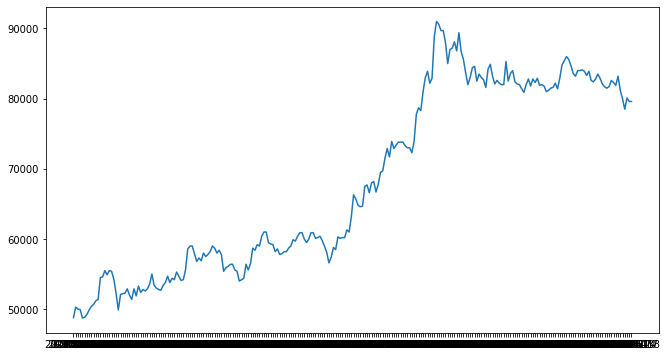

In [24]:
# 시간 변화에 따라 분산이 증가하는 모습을 보임
plt.plot(ts)

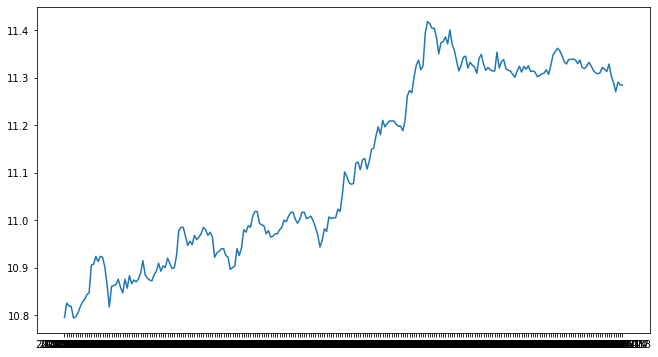

In [25]:
# 시간 추이에 따른 분산을 낮추기 위해 로그 변환 진행 
ts_log =  np.log(ts)

# 변환된 데이터 시각화 
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [26]:
# 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화하는 함수 정의 
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    # 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [27]:
from statsmodels.tsa.stattools import adfuller


# 시계열이 안정적인지 파악하는 augmented_dickey_fuller_test 정의
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)  

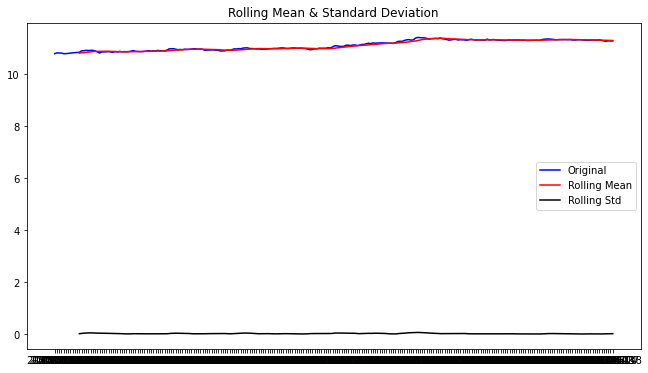

In [28]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

- 전체적으로 10보다 다소 높은 수준으로 유지되고 있으나, 그래프가 다소 우상향하는 모습을 보이고 있다.
- 우상향하는 트렌드가 존재하는 것으로 생각되어진다

In [29]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Test Statistic의 값이 -1.383525으로, ts_log 시게열 데이터가 stationary하지 않다는 귀무가설을 기각하기 어렵다

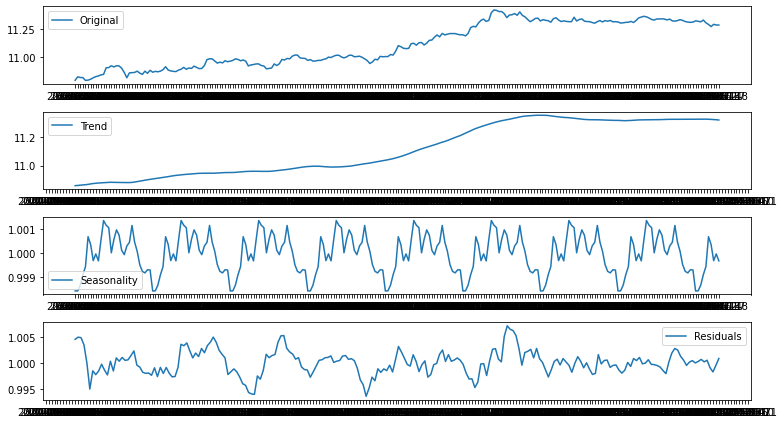

In [30]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 우상향하는 트렌드 존재
- Seasonality도 존재
- 트렌드와 Seasonality를 제외한 Residuals는 Stationary한 것으로 보임

더 자세한 확인을 위애, Residual의 안정성을 파악할 필요 있음

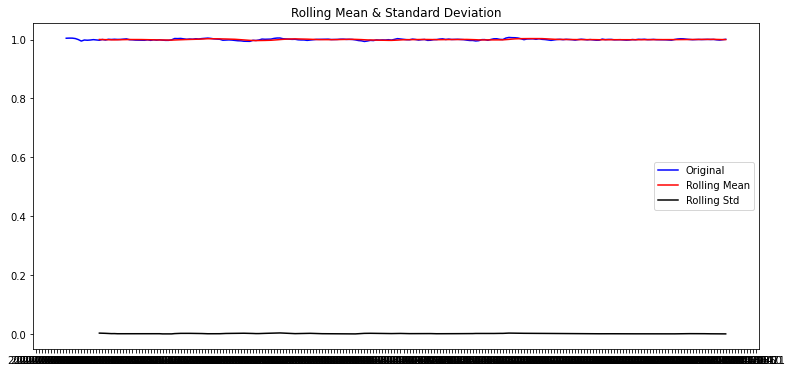

In [31]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

'1'을 기준으로 큰 변화없이 존재하는 것을 확인 
-> Trend 없을 것으로 생각되어짐

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Residual의 Test Statistic 값이 -6 정도로, 귀무가설을 기각하고, Residual이 Stationary하다는 대립가설을 채택할 수 있다

# STEP 4 : 학습, 테스트 데이터셋 생성

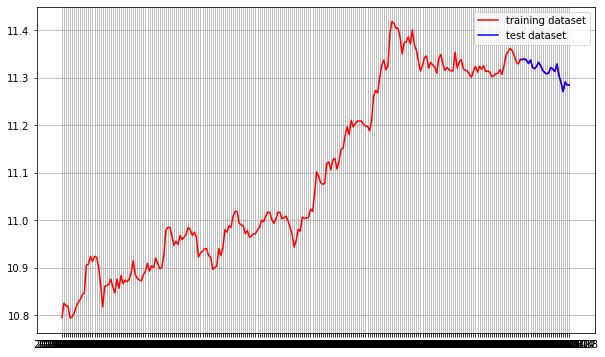

In [34]:
# 9:1로 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [35]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


# STEP 5 : 적정 ARIMA 모수 찾기

#### P와 Q (Trend와 Auto Regressive)

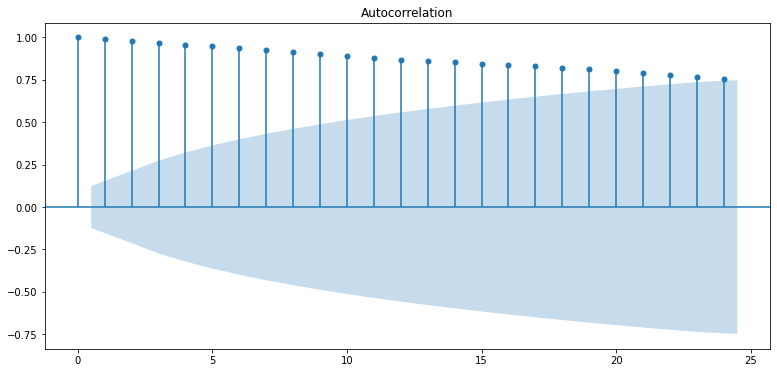

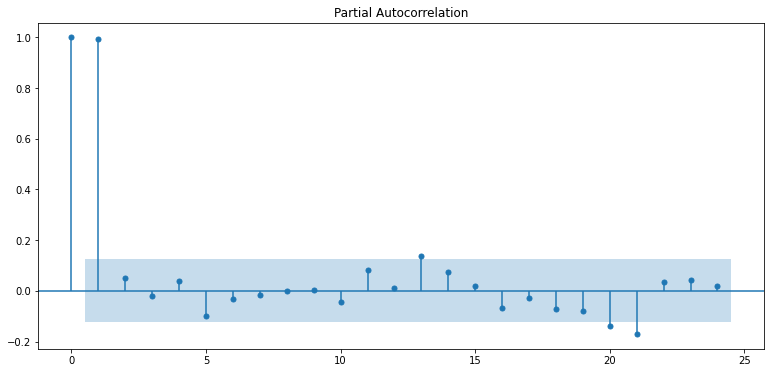

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF Plot
  점차적으로 감소하는 모습을 보임  --> ARIMA 모델의 Q 값을 크게 적절한 값이 없는 것으로 보임
  
- PACF Plot
  시차 1 이후에 0에 가까운 값들이 나오고 있다
  ---> ARIMA 모델의 P 값으로 1을 채택

#### D (Seasonality)

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


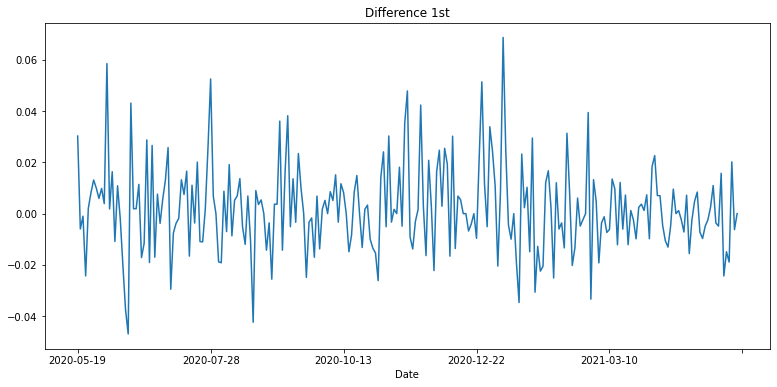

In [37]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 미분의 결과 Test Statistic의 값이 -1.5 정도로 귀무가설을 기각할 수 없음

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


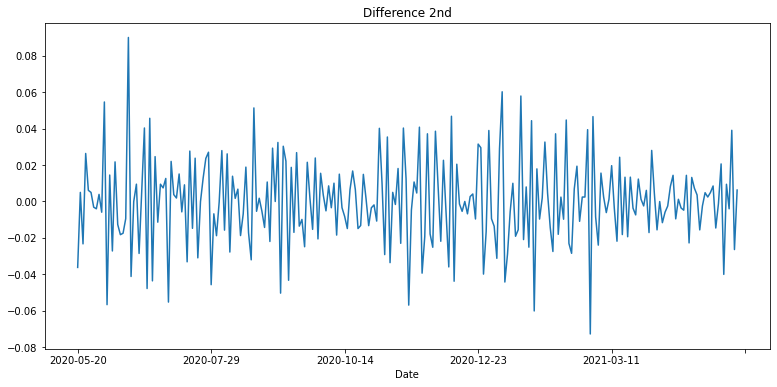

In [38]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 미분의 결과 Test Statistic의 값이 -1 정도로 귀무가설을 기각할 수 없음

Results of Dickey-Fuller Test:
Test Statistic                -8.066373e+00
p-value                        1.592247e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


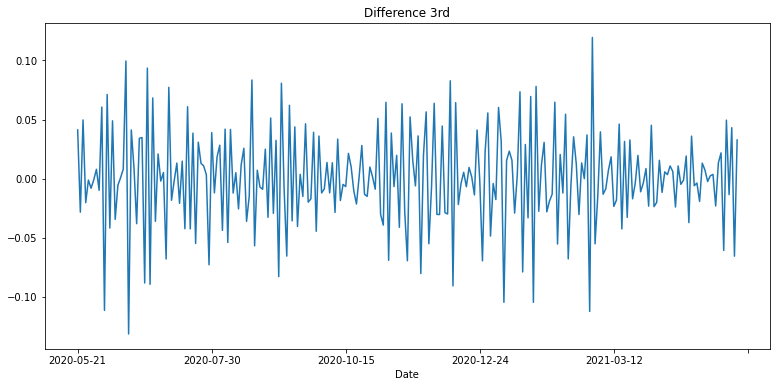

In [39]:
# 3차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

3차 차분의 결과 Test Statistic 값이 -8 정도로 귀무가설을 기각할 수 있고, 3차 차분한 값이 충분히 Stationary하다는 대립가설을 채택할 수 있다

그 결과 D의 값은 3을 채택

# STEP 6 : ARIMA 모델 훈련과 테스트

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 3))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 3)   Log Likelihood                 583.728
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1155.456
Time:                        07:51:16   BIC                          -1134.959
Sample:                             0   HQIC                         -1147.183
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0690      0.211     52.513      0.000      10.656      11.482
ar.L1.Close     0.9973      0.003    294.443      0.000       0.991       1.004
ma.L1.Close     0.0367      0.067      0.545    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

###### 시각화 

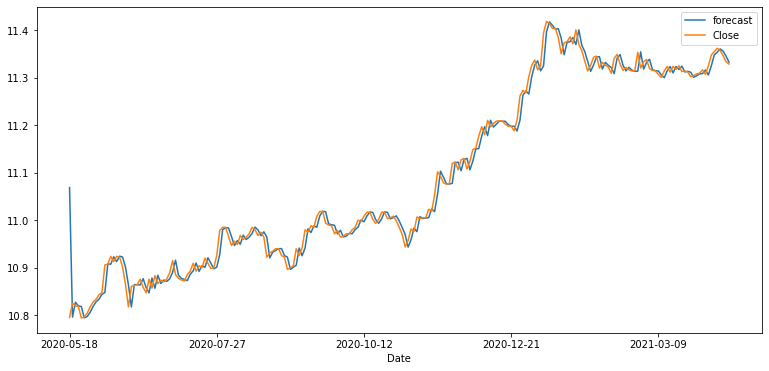

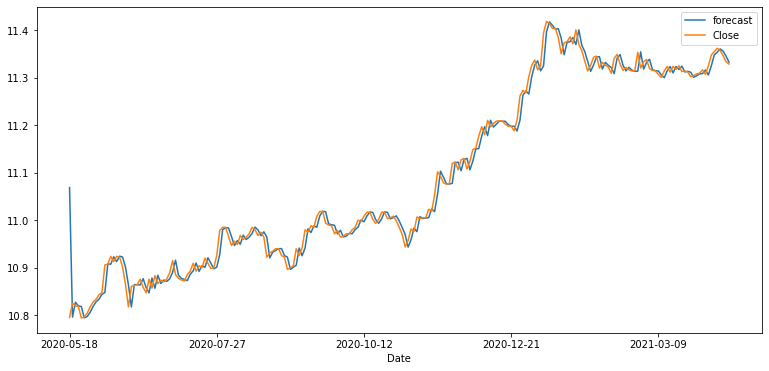

In [41]:
fitted_m.plot_predict()

###### forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

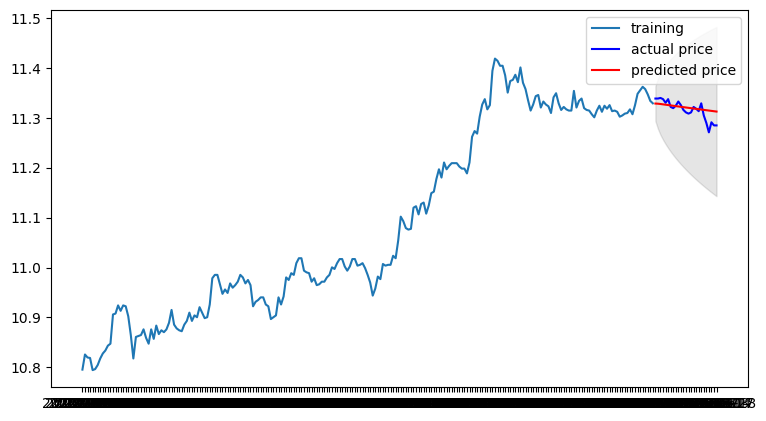

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

###### 지수 함수로 변환하여 실제 데이터와의 오차 확인

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1592188.1860632799
MAE:  964.8994094129174
RMSE:  1261.819395184303
MAPE: 1.19%


# STEP 7 : 다른 주식 종목 예측해 보기

# SoftBank

# STEP 1 : 시계열 데이터 준비

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/SoftBank.csv' 
df = pd.read_csv(dataset_filepath, index_col = 'Date')
ts = df['Close']

# Adj Close : 수정 종가 
ts.head()

Date
2020-09-07    5881.0
2020-09-08    5845.0
2020-09-09    5677.0
2020-09-10    5800.0
2020-09-11    5860.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

###### 결측치 처리

In [45]:
# 결측치 X
ts.isnull().sum()

ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

###### 로그 변환

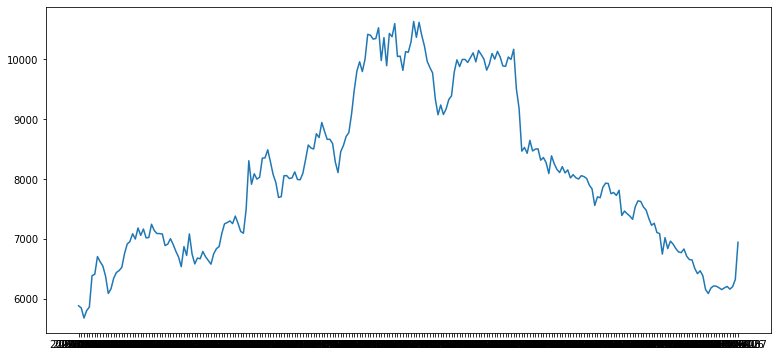

In [46]:
# 분산이 크게 나타나고 있음 
plt.plot(ts)

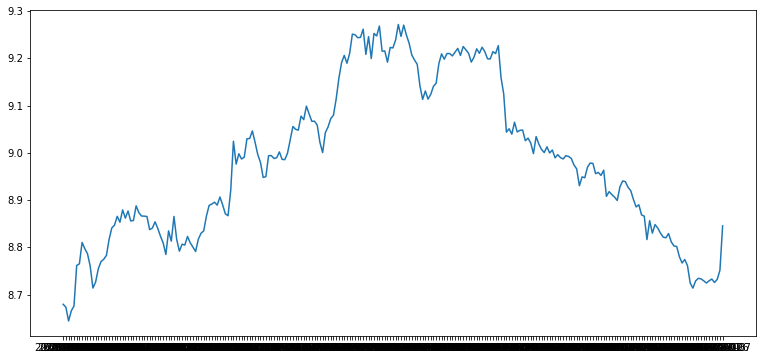

In [47]:
# 분산을 낮추기 위해 로그 변환 진행 
ts_log =  np.log(ts)

# 변환된 데이터 시각화 
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

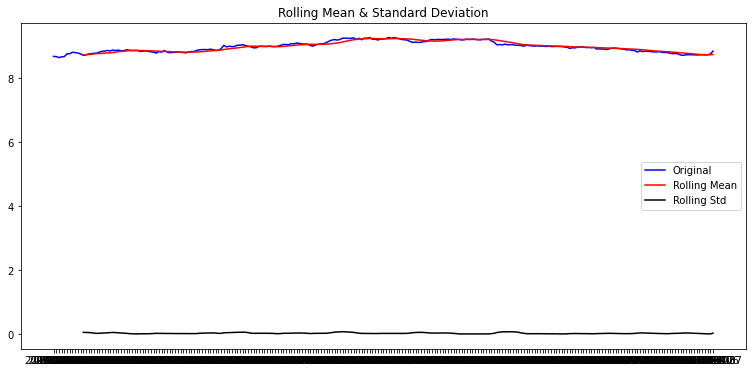

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

- 전체적으로 8보다 다소 높은 수준으로 유지되고 있음
- 그래프 상으로는 크게 증가하거나 감소하는 트렌드가 나타나지는 않는다

In [49]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.111215
p-value                          0.240029
#Lags Used                       2.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


Test Statistic의 값이 ts_log 시게열 데이터가 stationary하지 않다는 귀무가설을 기각하기 어렵다

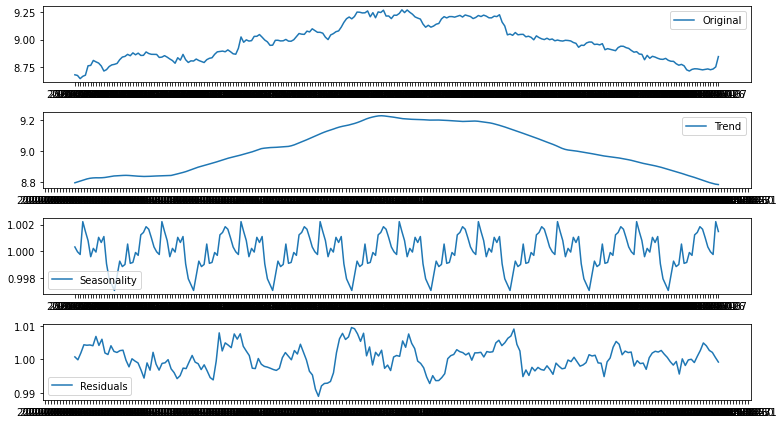

In [50]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 우상향했다가 우하향 하는 Trend 확인
- Seasonality도 존재
- 트렌드와 Seasonality를 제외한 Residuals는 Stationary한 것으로 보임

더 자세한 확인을 위애, Residual의 안정성을 파악할 필요 있음

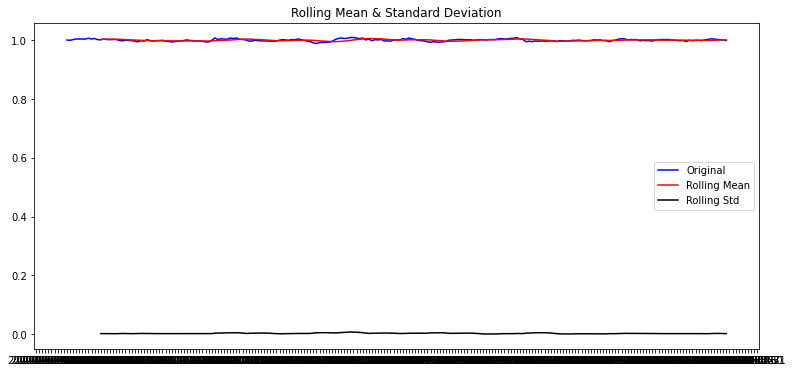

In [51]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

'1'을 기준으로 큰 변화없이 존재하는 것을 확인 
-> Trend 없을 것으로 생각되어짐

In [52]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.853679e+00
p-value                        3.540779e-07
#Lags Used                     5.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


Residual의 Test Statistic 값이 -5.8 정도로, 귀무가설을 기각하고, Residual이 Stationary하다는 대립가설을 채택할 수 있다

# STEP 4 : 학습, 테스트 데이터셋 생성

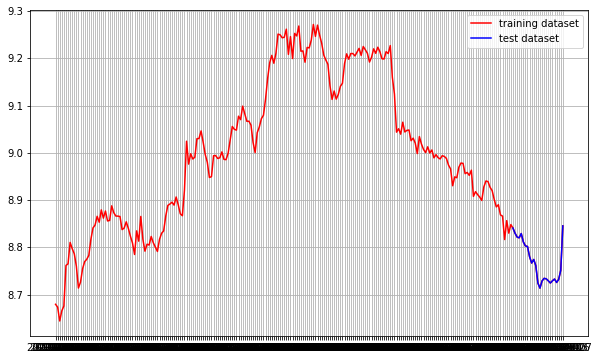

In [53]:
# 9:1로 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [54]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-07    8.679482
2020-09-08    8.673342
Name: Close, dtype: float64
(220,)
(25,)


# STEP 5 : 적정 ARIMA 모수 찾기

#### P와 Q (Trend와 Auto Regressive)

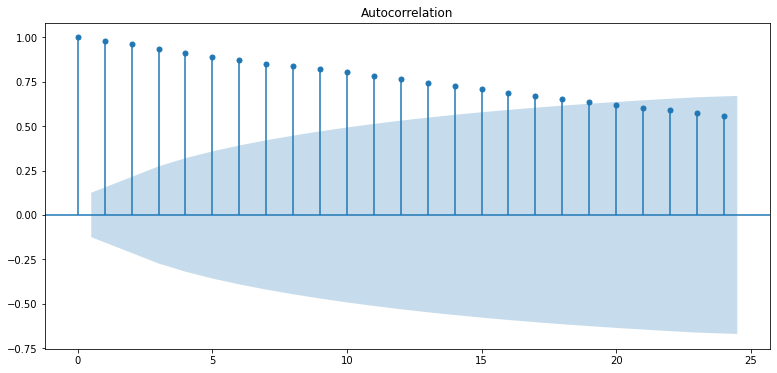

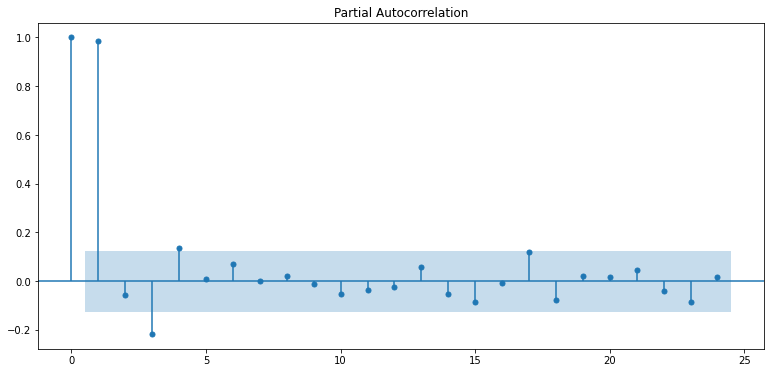

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF Plot
  점차적으로 감소하는 모습을 보임  --> ARIMA 모델의 Q 값을 크게 적절한 값이 없는 것으로 보임
  
- PACF Plot
  시차 1 이후에 0에 가까운 값들이 나오고 있다
  ---> ARIMA 모델의 P 값으로 1을 채택

#### D (Seasonality)

Results of Dickey-Fuller Test:
Test Statistic                -8.486659e+00
p-value                        1.347591e-13
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


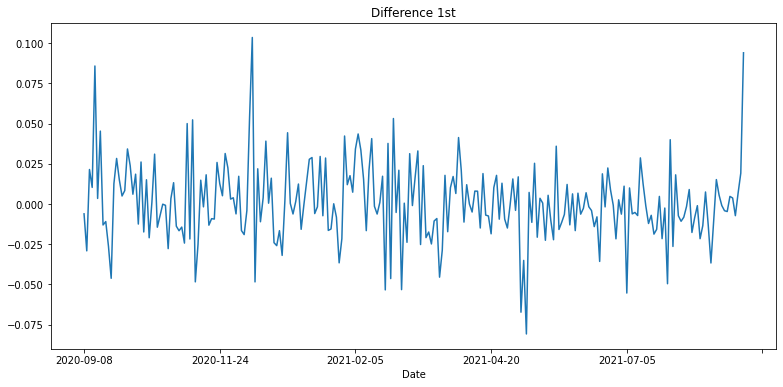

In [56]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 미분의 결과로 충분히 안정적인 결과가 나타남

그 결과 D의 값은 1을 채택

# STEP 6 : ARIMA 모델 훈련과 테스트

In [57]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  220
Model:                     ARMA(1, 1)   Log Likelihood                 501.718
Method:                       css-mle   S.D. of innovations              0.025
Date:                Tue, 07 Sep 2021   AIC                           -995.435
Time:                        08:24:46   BIC                           -981.861
Sample:                             0   HQIC                          -989.954
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.8782      0.141     63.053      0.000       8.602       9.154
ar.L1.Close     0.9916      0.007    138.412      0.000       0.978       1.006
ma.L1.Close    -0.0408      0.057     -0.712    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

###### 시각화 

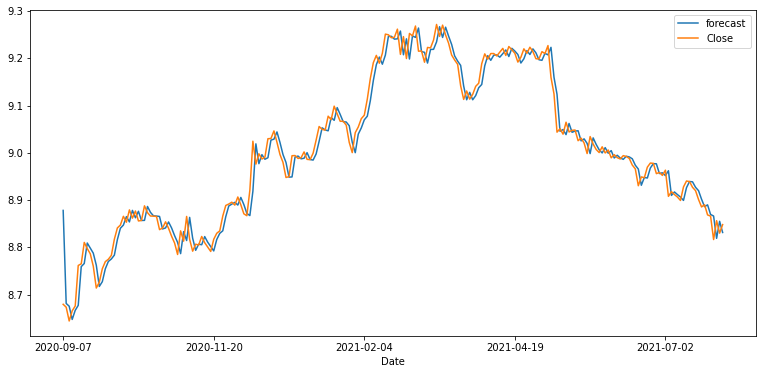

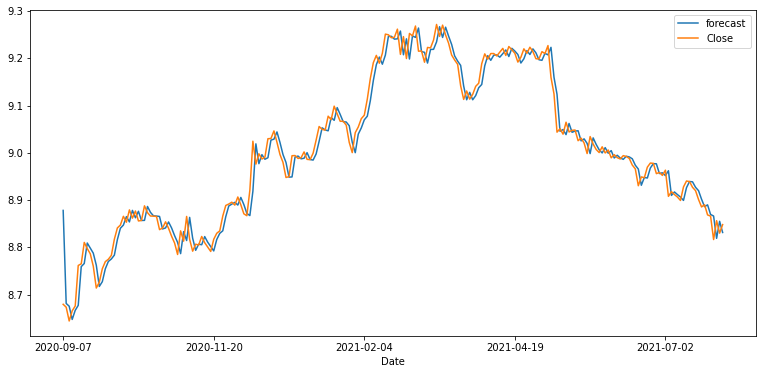

In [58]:
fitted_m.plot_predict()

###### forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

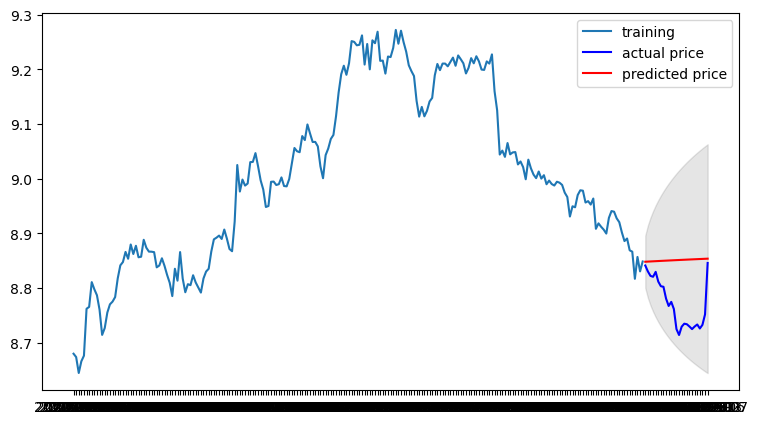

In [59]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

###### 지수 함수로 변환하여 실제 데이터와의 오차 확인

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  370771.487743322
MAE:  535.4772856499154
RMSE:  608.9100818210534
MAPE: 8.52%


# FaceBook

# STEP 1 : 시계열 데이터 준비

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/FaceBook.csv' 
df = pd.read_csv(dataset_filepath, index_col = 'Date')
ts = df['Close']

# Adj Close : 수정 종가 
ts.head()

Date
2020-09-08    271.160004
2020-09-09    273.720001
2020-09-10    268.089996
2020-09-11    266.609985
2020-09-14    266.149994
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

###### 결측치 처리

In [79]:
# 결측치 X
ts.isnull().sum()

ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

###### 로그 변환

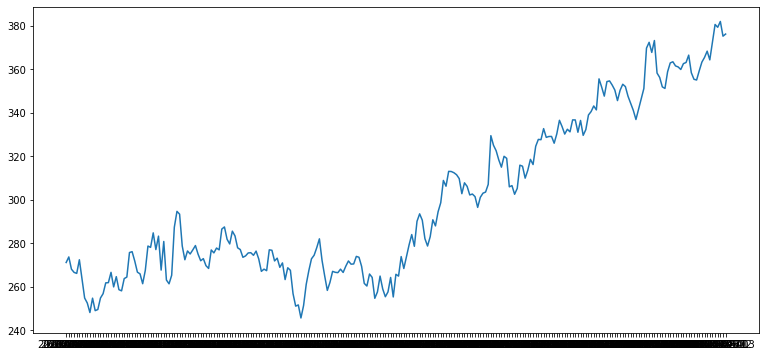

In [80]:
# 분산이 크게 나타나고 있음 
plt.plot(ts)

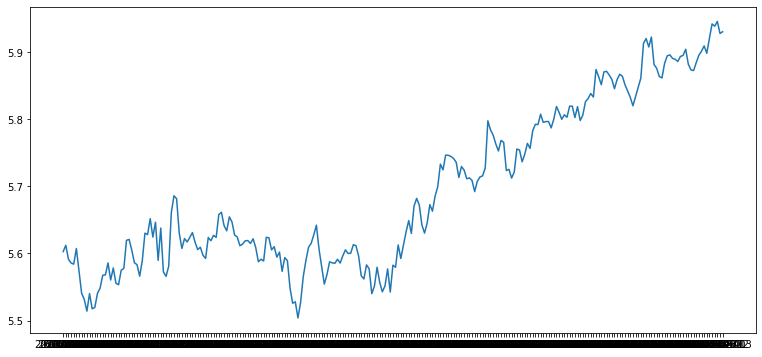

In [81]:
# 분산을 낮추기 위해 로그 변환 진행 
ts_log =  np.log(ts)

# 변환된 데이터 시각화 
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

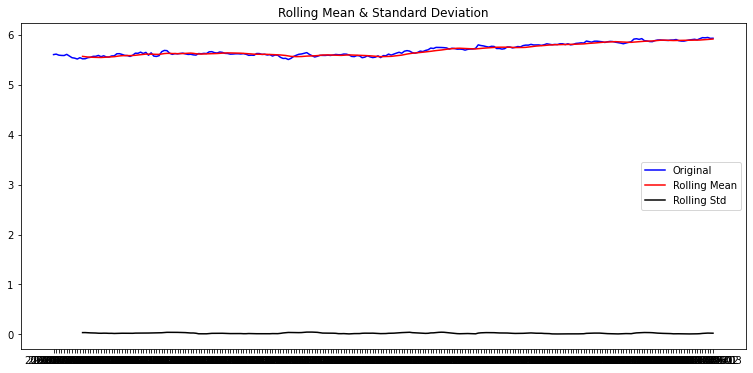

In [82]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

- 전체적으로 6에 가까운 수준으로 유지되고 있음
- 그래프 상으로는 다소 증가하는 모습을 보임

In [83]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.006414
p-value                          0.959059
#Lags Used                       5.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


Test Statistic의 값이 ts_log 시게열 데이터가 stationary하지 않다는 귀무가설을 기각하기 어렵다

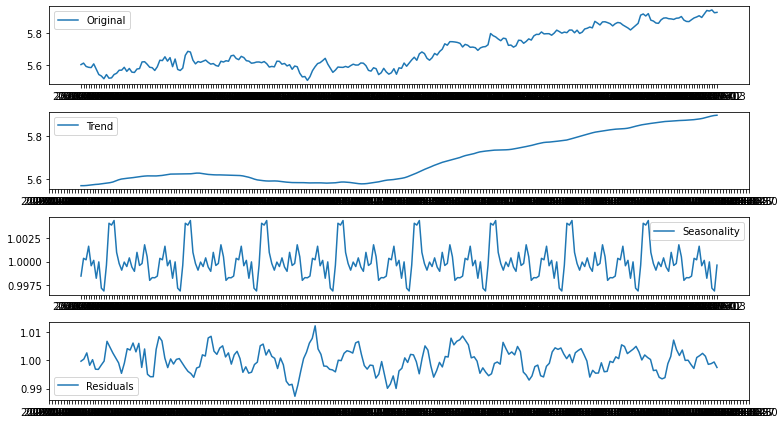

In [84]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 우상향하는 Trend 확인
- Seasonality도 존재
- 트렌드와 Seasonality를 제외한 Residuals는 Stationary한 것으로 보임

더 자세한 확인을 위애, Residual의 안정성을 파악할 필요 있음

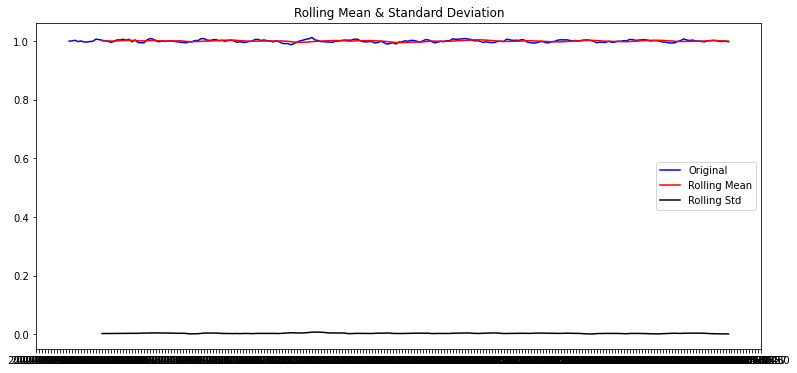

In [85]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

'1'을 기준으로 큰 변화없이 존재하는 것을 확인 
-> Trend 없을 것으로 생각되어짐

In [86]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.828163e+00
p-value                        1.923955e-09
#Lags Used                     4.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


Residual의 Test Statistic 값이 -6.8 정도로, 귀무가설을 기각하고, Residual이 Stationary하다는 대립가설을 채택할 수 있다

# STEP 4 : 학습, 테스트 데이터셋 생성

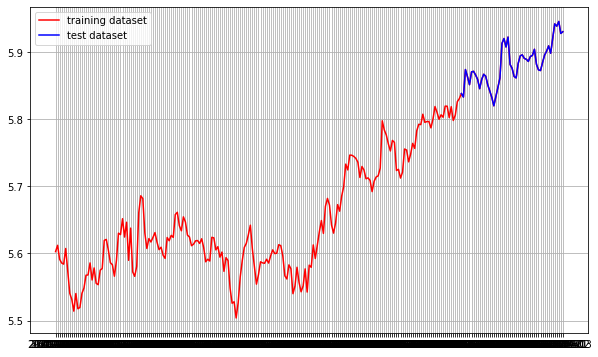

In [87]:
# 8:2로 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [88]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-08    5.602709
2020-09-09    5.612106
Name: Close, dtype: float64
(200,)
(51,)


# STEP 5 : 적정 ARIMA 모수 찾기

#### P와 Q (Trend와 Auto Regressive)

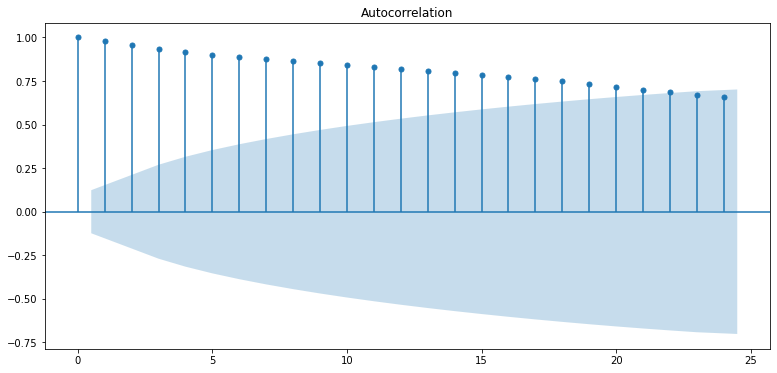

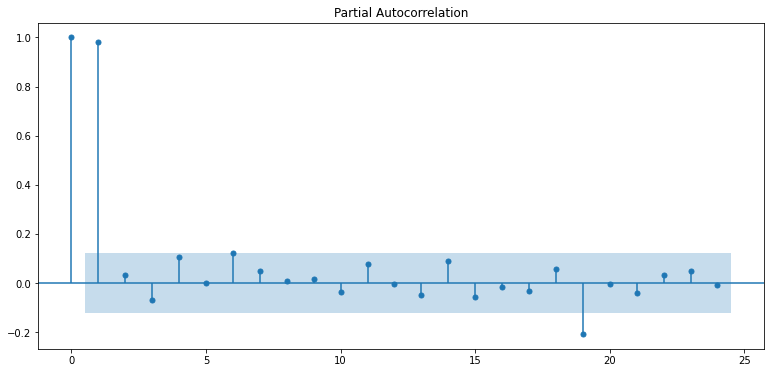

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF Plot
  점차적으로 감소하는 모습을 보임  --> ARIMA 모델의 Q 값을 크게 적절한 값이 없는 것으로 보임
  
- PACF Plot
  시차 1 이후에 0에 가까운 값들이 나오고 있다
  ---> ARIMA 모델의 P 값으로 1을 채택

#### D (Seasonality)

Results of Dickey-Fuller Test:
Test Statistic                -8.272850e+00
p-value                        4.741847e-13
#Lags Used                     6.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


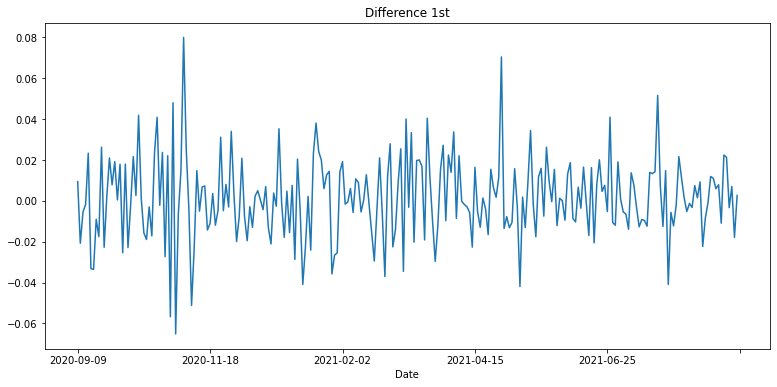

In [90]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 미분의 결과로 충분히 안정적인 결과가 나타남

그 결과 D의 값은 1을 채택

# STEP 6 : ARIMA 모델 훈련과 테스트

In [99]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  199
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 491.295
Method:                       css-mle   S.D. of innovations              0.020
Date:                Tue, 07 Sep 2021   AIC                           -974.590
Time:                        09:45:51   BIC                           -961.417
Sample:                             1   HQIC                          -969.259
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      0.803      0.422      -0.002       0.004
ar.L1.D.Close    -0.9499      0.062    -15.302      0.000      -1.072      -0.828
ma.L1.D.Close     0.9020      0.087     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

###### 시각화 

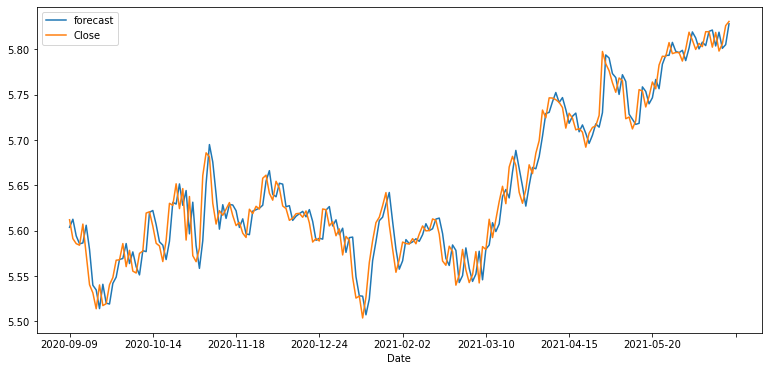

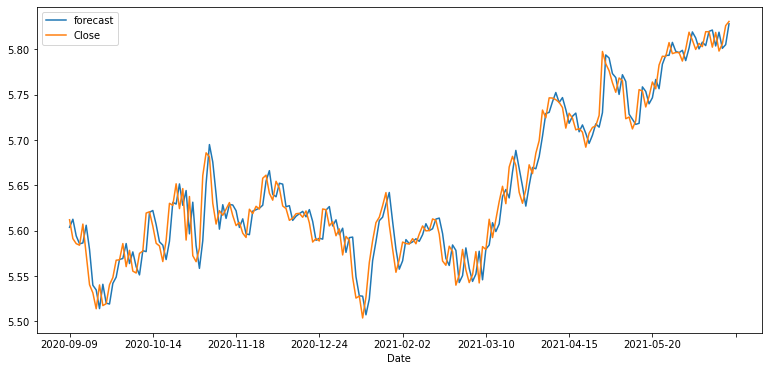

In [100]:
fitted_m.plot_predict()

###### forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

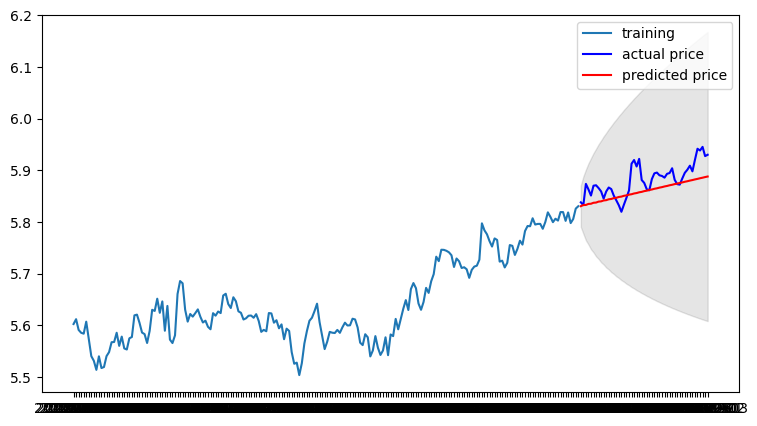

In [101]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

###### 지수 함수로 변환하여 실제 데이터와의 오차 확인

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  118.39121231691394
MAE:  8.799581422117106
RMSE:  10.8807725974268
MAPE: 2.42%


# 결론

- ARIMA 모델 파라미터로 (1,0,1)을 주었을 때, 
 MAPE 10.91% 기록
- ARIMA 모델 파라미터로 (1,1,1)을 주었을 때, 
 MAPE 2.42%로 성능 향상을 기록
 
코로나 이후 기업들의 주가 상승으 크게 일어나면서, 
전반적으로 주가가 우상향하는 Trend를 보였음

이 상황에서, ACP Plot을 기반으로 하여, q 값으로 0을 주었을 때는 
ARIMA 모델의 이동평균이 최근 주식 시장의 활황을 충분히 반영하지 못하여,
잘 예측하지 못하는 경우가 나오는 것을 확인하였다.

다음의 소프트뱅크 주가 예측 보다, 
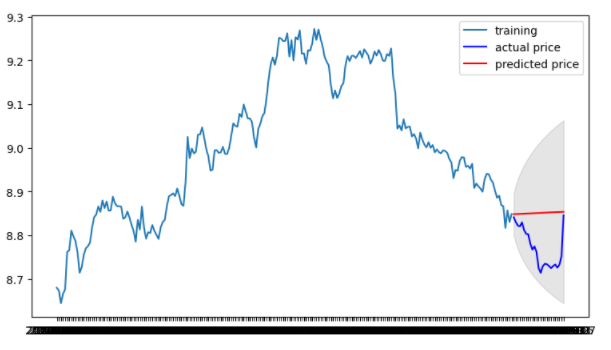

q 값을 1을 주는 페이스북 주가 예측의 사례가 
최근의 주가 움직임을 더 잘 반영하였다

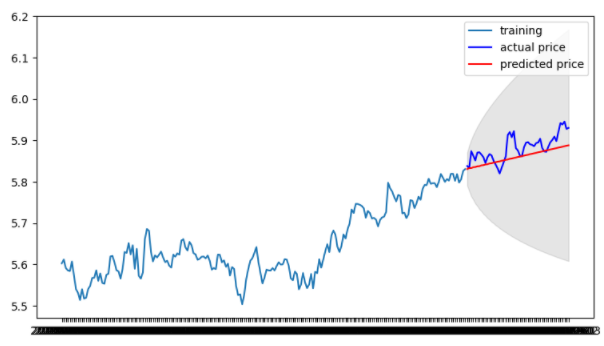


ACF Plot에서 시차에 따라 점점 감소하는 추이가 나타나는 경우에 대해서도
충분히 하이퍼파라미터 튜닝을 통해, 적절한 q 값을 찾을 수 있도록 노력해야함을 경험적으로 깨달을 수 있었다.
